<img src="sketch.png" width=600>

In [1]:
import torch
import torch.distributions as D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def mean_function(x, theta):
    """
    This function defines the relation between the data and the mean of the 
    approximate posterior q(z|x), or N(z|mu(x), sigma) that conditions on x.
    
    Input:
        x: Tensor [batch]
        theta: float
        
    Output:
        mu: Tensor [batch]
    """
    mu = x - theta
    return mu

def gauss_encode(x, theta, sigma):
    """
    Super simple Gaussian encoder, which conditions on the data via the 
    transformation defined by mean_function. The parameters of the model 
    are theta and sigma.
    
    Input:
        x: Tensor [batch]
        theta: float
        sigma: float
    
    Output:
        q_z_x_dist: Distribution [batch]
        z_sample: Tensor [batch]
    """
    
    mu = mean_function(x, theta)
    sigma_exp = torch.FloatTensor([sigma]).expand_as(x)
    
    assert (sigma_exp <= 0).sum() == 0, "Sigma needs to be larger than 0."
    
    q_z_x_dist = D.Normal(mu, sigma)
    z_sample = q_z_x_dist.rsample()
    
    return q_z_x_dist, z_sample

def gauss_decode(z, sigma=1):
    """
    Gaussian decoder that conditions on z in the form of simple identity (mu = z).
    An additional hyperparameter is sigma.
    
    Input:
        z: Tensor [batch]
    
    Output:
        elbo: float
        rate: float
        dist: float
    """
    
    # 
    p_x_z = D.Normal(z, sigma)
    x_recon = p_x_z.rsample()
    ll = p_x_z.log_prob(x_recon)
    return ll

def kl_div_post_prior(posterior):
    prior = D.Normal(0.0, 1.0)
    return D.kl.kl_divergence(posterior, prior)

def elbo(samples, theta, sigma):
    q_z_x_dist, z_sample = gauss_encode(samples, theta, sigma)
    rate = kl_div_post_prior(q_z_x_dist)
    dist = - gauss_decode(z_sample) # nll
    elbo_val = - (rate + dist)
    return elbo_val.mean(), rate.mean(), dist.mean()

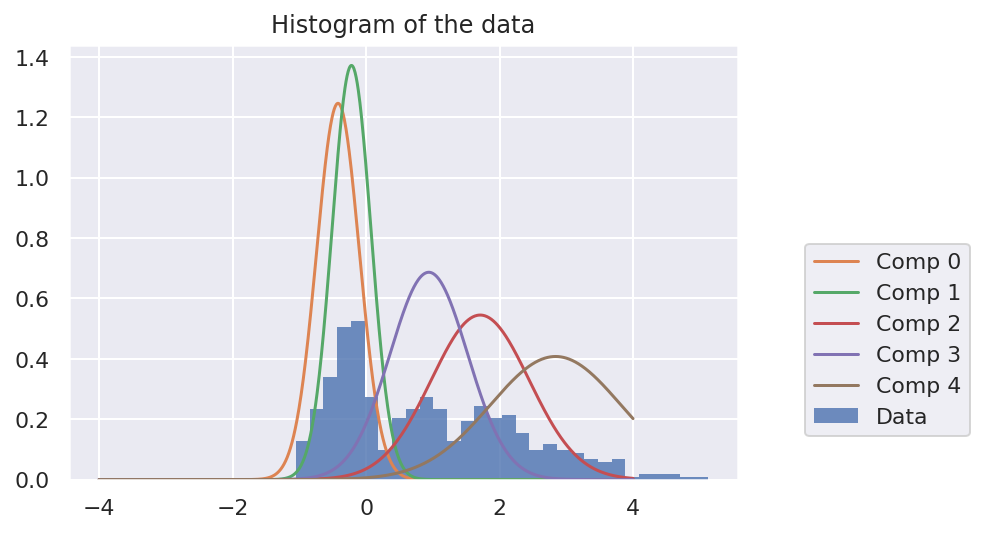

In [3]:
# Data, mixture of Gaussians
N_data_points, N_components = 500, 5
mix = D.Categorical(torch.ones(N_components,))
# mix = D.Categorical(torch.softmax(torch.randn(N_components,), 0))
comp = D.Normal(torch.randn(N_components,), torch.rand(N_components,))
gmm = D.mixture_same_family.MixtureSameFamily(mix, comp)
data = gmm.sample(sample_shape=(N_data_points,))

# Plot the Data
_  = plt.hist(data.numpy(), bins=30, linewidth=0.0, alpha=0.8, density=True, label="Data")
plt.title("Histogram of the data")
x = torch.linspace(-4, 4, 1000)
res = comp.log_prob(x[:, None]).exp()
for i in range(N_components):
    plt.plot(x, res[:, i], label=f"Comp {i}")
_ = plt.legend(loc=(1.1, 0.1))

In [4]:
%%time 

n_param_vals = 100

theta_low, theta_high = -1, 1
sigma_low, sigma_high = 0.001, 1

thetas = torch.linspace(theta_low, theta_high, n_param_vals)
sigmas = torch.linspace(sigma_low, sigma_high, n_param_vals)

elbo_land_scape = torch.empty((n_param_vals, n_param_vals))
rate_land_scape = torch.empty((n_param_vals, n_param_vals))
dist_land_scape = torch.empty((n_param_vals, n_param_vals))

for x_i, t in enumerate(thetas):
    for y_i, s in enumerate(sigmas):
        
        elbo_val, rate, dist = elbo(data, t, s)
        
        elbo_land_scape[x_i, y_i] = elbo_val  
        rate_land_scape[x_i, y_i] = rate  
        dist_land_scape[x_i, y_i] = dist  

CPU times: user 11.3 s, sys: 0 ns, total: 11.3 s
Wall time: 11.3 s


# Plot ELBO, parameter landscape

$$ x \sim p_\mathcal{D}(x) = \sum_i^K \pi_i N(\mu_i, \sigma_i) $$
$$ \text{Encoder: } q(z|x) = \mathcal{N}(x - \theta, \sigma) $$
$$ \text{Decoder: } p(x|z) = \mathcal{N}(z, \sigma) $$

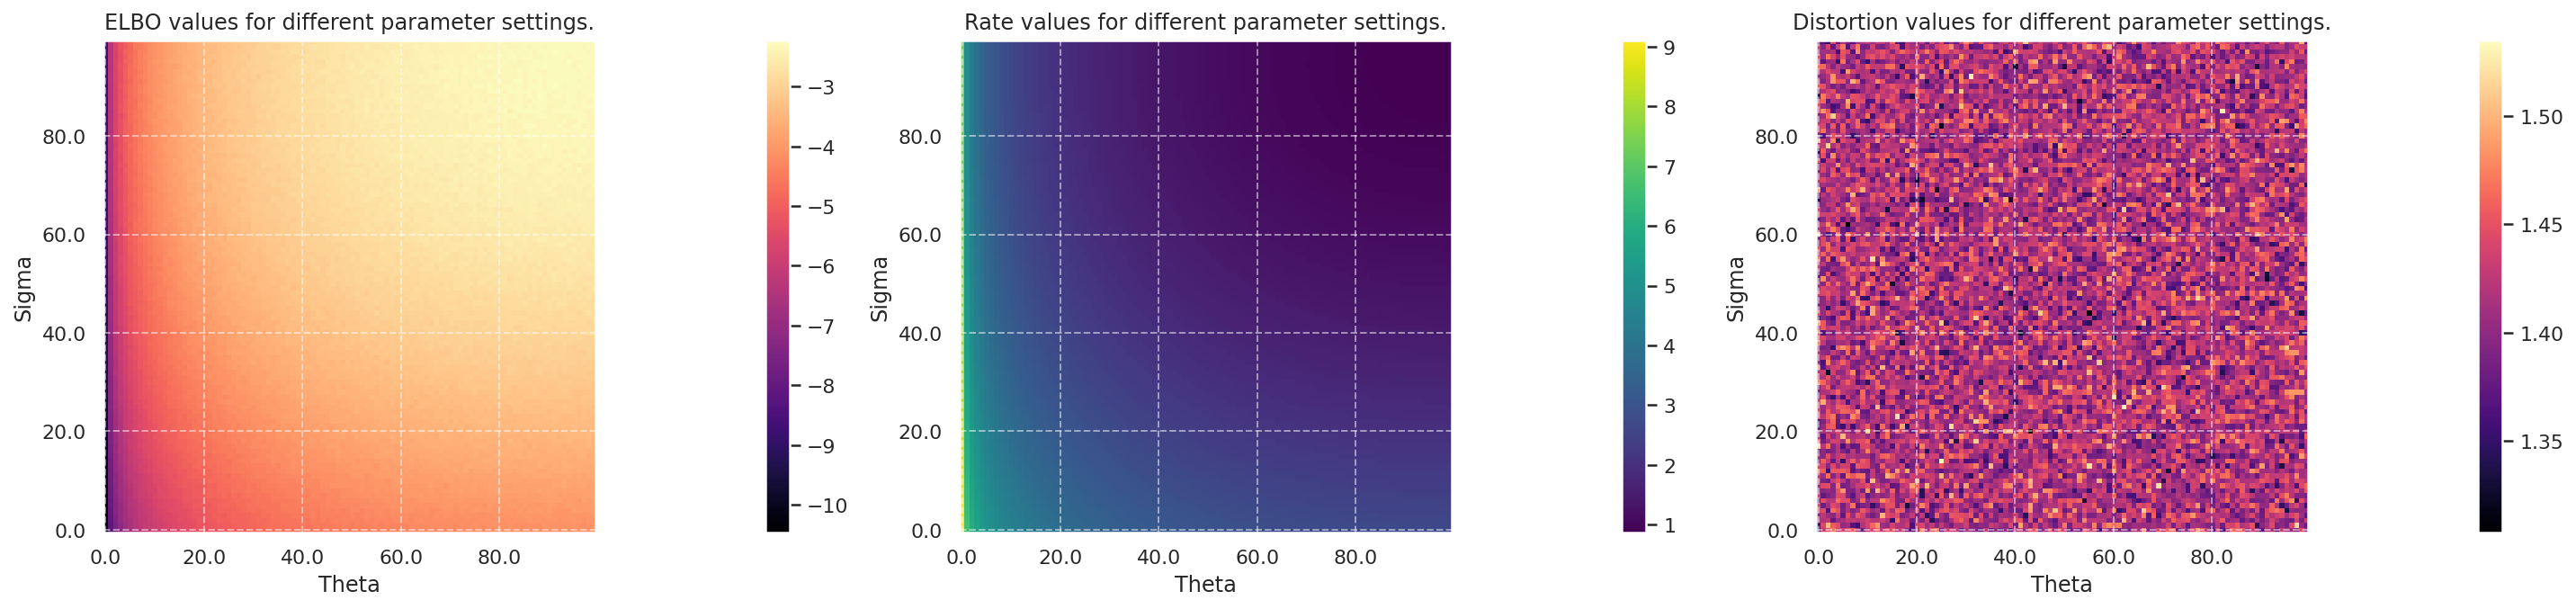

In [5]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(20, 8), gridspec_kw={'width_ratios':[1, 0.05, 1, 0.05, 1, 0.05]})

# ELBO landscape
im_elbo = ax[0].imshow(elbo_land_scape.numpy(), origin="lower", cmap="magma")

locs = np.arange(0, len(thetas), 20)
ax[0].set_xticks(locs)
ax[0].set_xticklabels(thetas.numpy()[locs])
ax[0].xaxis.set_major_formatter('{x:.1f}')

ax[0].set_yticks(locs)
ax[0].set_yticklabels(sigmas.numpy()[locs])
ax[0].yaxis.set_major_formatter('{x:.1f}')

ax[0].set_xlabel("Theta")
ax[0].set_ylabel("Sigma")

ax[0].grid(color='white', linestyle='dashed', alpha=0.5)
_ = plt.colorbar(im_elbo, ax=ax[1], fraction=1.0)
ax[0].set_title("ELBO values for different parameter settings.")

# Rate landscape
im_rate = ax[2].imshow(rate_land_scape.numpy(), origin="lower", cmap="viridis")
locs = np.arange(0, len(thetas), 20)
ax[2].set_xticks(locs)
ax[2].set_xticklabels(thetas.numpy()[locs])
ax[2].xaxis.set_major_formatter('{x:.1f}')

ax[2].set_yticks(locs)
ax[2].set_yticklabels(sigmas.numpy()[locs])
ax[2].yaxis.set_major_formatter('{x:.1f}')

ax[2].set_xlabel("Theta")
ax[2].set_ylabel("Sigma")

ax[2].grid(color='white', linestyle='dashed', alpha=0.5)
_ = plt.colorbar(im_rate, ax=ax[3], fraction=1.0)
ax[2].set_title("Rate values for different parameter settings.")

# Distortion landscape
im_dist = ax[4].imshow(dist_land_scape.numpy(), origin="lower", cmap="magma")
locs = np.arange(0, len(thetas), 20)
ax[4].set_xticks(locs)
ax[4].set_xticklabels(thetas.numpy()[locs])
ax[4].xaxis.set_major_formatter('{x:.1f}')

ax[4].set_yticks(locs)
ax[4].set_yticklabels(sigmas.numpy()[locs])
ax[4].yaxis.set_major_formatter('{x:.1f}')

ax[4].set_xlabel("Theta")
ax[4].set_ylabel("Sigma")

ax[4].grid(color='white', linestyle='dashed', alpha=0.5)
_ = plt.colorbar(im_dist, ax=ax[5], fraction=1.0)
ax[4].set_title("Distortion values for different parameter settings.")

for a in [1, 3, 5]:
    plt.delaxes(ax[a])

plt.tight_layout()